In [38]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from transformers.dummies_encoder import DummiesEncoder
from transformers.item_selector import ItemSelector
from transformers.morphology_extractor import MorphologyExtractor
from transformers.dict_class_transformer import DictClassTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.datasets import dump_svmlight_file
from transformers.multi_label_encoder import MultiLabelEncoder
from transformers.reshape_2d import Reshape2D
from transformers.pandas_union import PandasUnion
from transformers.string_splitter import StringSplitter
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

INPUT_PATH = r'../input/norm_challenge_ru'
DATA_INPUT_PATH = r'../input/norm_challenge_ru/ru_with_types'
SUBM_PATH = INPUT_PATH

#Prepare data

In [26]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'ru_train.csv'),
                 encoding='utf-8',
                 index_col=False,
                 usecols=['before', 'class'])
df = df.sample(100000, random_state=2017)

df['before_prev'] = df['before'].shift(1)
df['before_next'] = df['before'].shift(-1)
df['before_len'] = df['before'].str.len()
df['before_wc'] = df['before'].map(lambda x: len(str(x).split()))
df = df.fillna('')
print(df.info())

pipeline = Pipeline([
    # ('features', FeatureUnion([
    ('features', PandasUnion([
        ('chars', Pipeline([
            ('select', ItemSelector('before')),
            ('split', StringSplitter(20))
        ])),
        ('context', Pipeline([
            ('select', ItemSelector('before')),
            ('extract', MorphologyExtractor()),
            ('one_hot', DummiesEncoder())
        ])),
        ('chars_prev', Pipeline([
            ('select', ItemSelector('before_prev')),
            ('split', StringSplitter(10))
        ])),
        ('context_prev', Pipeline([
            ('select', ItemSelector('before_prev')),
            ('extract', MorphologyExtractor()),
            ('one_hot', DummiesEncoder())
        ])),
        ('chars_next', Pipeline([
            ('select', ItemSelector('before_next')),
            ('split', StringSplitter(10))
        ])),
        ('context_next', Pipeline([
            ('select', ItemSelector('before_next')),
            ('extract', MorphologyExtractor()),
            ('one_hot', DummiesEncoder())
        ])),
    ])),
])

x_data = pipeline.fit_transform(df.drop(['class'], axis=1))
print(x_data.shape)

y_data = pd.factorize(df['class'])
labels = y_data[1]
y_data = y_data[0]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=2017)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 4656679 to 6714492
Data columns (total 6 columns):
class          100000 non-null object
before         100000 non-null object
before_prev    100000 non-null object
before_next    100000 non-null object
before_len     100000 non-null int64
before_wc      100000 non-null int64
dtypes: int64(2), object(4)
memory usage: 5.3+ MB
None


MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   2%|▏         | 1633/100000 [00:00<00:06, 16316.63it/s]

MorphologyExtractor transform:   4%|▎         | 3596/100000 [00:00<00:05, 17972.18it/s]

MorphologyExtractor transform:   5%|▍         | 4627/100000 [00:00<00:06, 13950.61it/s]

MorphologyExtractor transform:   7%|▋         | 6672/100000 [00:00<00:06, 15454.75it/s]

MorphologyExtractor transform:   9%|▉         | 8850/100000 [00:00<00:05, 16643.13it/s]

MorphologyExtractor transform:  11%|█         | 11050/100000 [00:00<00:05, 17480.50it/s]

MorphologyExtractor transform:  13%|█▎        | 13256/100000 [00:00<00:04, 18102.76it/s]

MorphologyExtractor transform:  15%|█▌        | 15121/100000 [00:00<00:04, 17274.45it/s]

MorphologyExtractor transform:  17%|█▋        | 16818/100000 [00:00<00:04, 16829.40it/s]

MorphologyExtractor transform:  19%|█▊        | 18600/100000 [00:01<00:04, 16918.06it/s]

MorphologyExtractor transform:  20%|██        | 20488/100000 [00:01<00:04, 17081.65it/s]

MorphologyExtractor transform:  22%|██▏       | 22378/100000 [00:01<00:04, 17221.43it/s]

MorphologyExtractor transform:  24%|██▍       | 24152/100000 [00:01<00:04, 16529.15it/s]

MorphologyExtractor transform:  26%|██▌       | 25761/100000 [00:01<00:04, 16497.88it/s]

MorphologyExtractor transform:  27%|██▋       | 27342/100000 [00:01<00:04, 16087.31it/s]

MorphologyExtractor transform:  29%|██▉       | 28792/100000 [00:01<00:04, 15870.79it/s]

MorphologyExtractor transform:  31%|███       | 30764/100000 [00:01<00:04, 16071.84it/s]

MorphologyExtractor transform:  33%|███▎      | 33244/100000 [00:02<00:04, 16505.10it/s]

MorphologyExtractor transform:  36%|███▌      | 35604/100000 [00:02<00:03, 16840.29it/s]

MorphologyExtractor transform:  38%|███▊      | 38064/100000 [00:02<00:03, 17189.73it/s]

MorphologyExtractor transform:  40%|████      | 40467/100000 [00:02<00:03, 17485.27it/s]

MorphologyExtractor transform:  43%|████▎     | 42683/100000 [00:02<00:03, 17032.93it/s]

MorphologyExtractor transform:  45%|████▌     | 45187/100000 [00:02<00:03, 17339.53it/s]

MorphologyExtractor transform:  48%|████▊     | 47640/100000 [00:02<00:02, 17605.24it/s]

MorphologyExtractor transform:  50%|█████     | 50273/100000 [00:02<00:02, 17916.13it/s]

MorphologyExtractor transform:  53%|█████▎    | 52920/100000 [00:02<00:02, 18210.13it/s]

MorphologyExtractor transform:  55%|█████▌    | 55429/100000 [00:03<00:02, 18438.78it/s]

MorphologyExtractor transform:  58%|█████▊    | 58088/100000 [00:03<00:02, 18701.17it/s]

MorphologyExtractor transform:  61%|██████    | 60599/100000 [00:03<00:02, 18833.76it/s]

MorphologyExtractor transform:  63%|██████▎   | 63033/100000 [00:03<00:02, 18372.90it/s]

MorphologyExtractor transform:  66%|██████▌   | 65725/100000 [00:03<00:01, 18614.93it/s]

MorphologyExtractor transform:  68%|██████▊   | 68215/100000 [00:03<00:01, 18788.02it/s]

MorphologyExtractor transform:  71%|███████   | 70613/100000 [00:03<00:01, 18926.86it/s]

MorphologyExtractor transform:  73%|███████▎  | 73290/100000 [00:03<00:01, 19131.54it/s]

MorphologyExtractor transform:  76%|███████▌  | 75915/100000 [00:03<00:01, 19312.48it/s]

MorphologyExtractor transform:  78%|███████▊  | 78441/100000 [00:04<00:01, 19460.02it/s]

MorphologyExtractor transform:  81%|████████  | 81149/100000 [00:04<00:00, 19644.47it/s]

MorphologyExtractor transform:  84%|████████▎ | 83715/100000 [00:04<00:00, 19774.16it/s]

MorphologyExtractor transform:  86%|████████▋ | 86428/100000 [00:04<00:00, 19943.89it/s]

MorphologyExtractor transform:  89%|████████▉ | 89024/100000 [00:04<00:00, 19478.49it/s]

MorphologyExtractor transform:  92%|█████████▏| 91692/100000 [00:04<00:00, 19632.48it/s]

MorphologyExtractor transform:  94%|█████████▍| 94261/100000 [00:04<00:00, 19759.40it/s]

MorphologyExtractor transform:  97%|█████████▋| 96956/100000 [00:04<00:00, 19907.02it/s]

MorphologyExtractor transform: 100%|█████████▉| 99656/100000 [00:04<00:00, 20049.70it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:04<00:00, 20052.35it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   2%|▏         | 1663/100000 [00:00<00:05, 16602.43it/s]

MorphologyExtractor transform:   4%|▎         | 3550/100000 [00:00<00:05, 17743.86it/s]

MorphologyExtractor transform:   5%|▌         | 5485/100000 [00:00<00:05, 18278.09it/s]

MorphologyExtractor transform:   7%|▋         | 7441/100000 [00:00<00:04, 18598.74it/s]

MorphologyExtractor transform:   9%|▉         | 9462/100000 [00:00<00:04, 18917.52it/s]

MorphologyExtractor transform:  12%|█▏        | 11523/100000 [00:00<00:04, 19171.99it/s]

MorphologyExtractor transform:  14%|█▍        | 13848/100000 [00:00<00:04, 19753.48it/s]

MorphologyExtractor transform:  16%|█▌        | 16015/100000 [00:00<00:04, 19991.96it/s]

MorphologyExtractor transform:  18%|█▊        | 18232/100000 [00:00<00:04, 20232.98it/s]

MorphologyExtractor transform:  20%|██        | 20292/100000 [00:01<00:04, 18612.04it/s]

MorphologyExtractor transform:  23%|██▎       | 22573/100000 [00:01<00:04, 18964.57it/s]

MorphologyExtractor transform:  25%|██▍       | 24849/100000 [00:01<00:03, 19258.10it/s]

MorphologyExtractor transform:  27%|██▋       | 27275/100000 [00:01<00:03, 19617.71it/s]

MorphologyExtractor transform:  30%|██▉       | 29662/100000 [00:01<00:03, 19901.92it/s]

MorphologyExtractor transform:  32%|███▏      | 32193/100000 [00:01<00:03, 20240.72it/s]

MorphologyExtractor transform:  35%|███▍      | 34505/100000 [00:01<00:03, 20400.72it/s]

MorphologyExtractor transform:  37%|███▋      | 36892/100000 [00:01<00:03, 20594.25it/s]

MorphologyExtractor transform:  39%|███▉      | 39425/100000 [00:01<00:02, 20839.08it/s]

MorphologyExtractor transform:  42%|████▏     | 41813/100000 [00:02<00:02, 19718.14it/s]

MorphologyExtractor transform:  44%|████▍     | 44148/100000 [00:02<00:02, 19881.62it/s]

MorphologyExtractor transform:  46%|████▋     | 46471/100000 [00:02<00:02, 20025.65it/s]

MorphologyExtractor transform:  49%|████▉     | 48856/100000 [00:02<00:02, 20183.53it/s]

MorphologyExtractor transform:  51%|█████▏    | 51325/100000 [00:02<00:02, 20362.18it/s]

MorphologyExtractor transform:  54%|█████▍    | 53815/100000 [00:02<00:02, 20534.75it/s]

MorphologyExtractor transform:  56%|█████▋    | 56399/100000 [00:02<00:02, 20729.74it/s]

MorphologyExtractor transform:  59%|█████▉    | 58952/100000 [00:02<00:01, 20899.76it/s]

MorphologyExtractor transform:  61%|██████▏   | 61415/100000 [00:02<00:01, 21011.93it/s]

MorphologyExtractor transform:  64%|██████▍   | 63928/100000 [00:03<00:01, 21148.04it/s]

MorphologyExtractor transform:  66%|██████▋   | 66395/100000 [00:03<00:01, 20327.79it/s]

MorphologyExtractor transform:  69%|██████▉   | 68848/100000 [00:03<00:01, 20452.42it/s]

MorphologyExtractor transform:  71%|███████▏  | 71315/100000 [00:03<00:01, 20573.85it/s]

MorphologyExtractor transform:  74%|███████▍  | 73846/100000 [00:03<00:01, 20706.48it/s]

MorphologyExtractor transform:  76%|███████▋  | 76363/100000 [00:03<00:01, 20828.16it/s]

MorphologyExtractor transform:  79%|███████▉  | 78892/100000 [00:03<00:01, 20946.59it/s]

MorphologyExtractor transform:  82%|████████▏ | 81622/100000 [00:03<00:00, 21110.86it/s]

MorphologyExtractor transform:  84%|████████▍ | 84249/100000 [00:03<00:00, 21239.16it/s]

MorphologyExtractor transform:  87%|████████▋ | 86960/100000 [00:04<00:00, 21383.00it/s]

MorphologyExtractor transform:  90%|████████▉ | 89558/100000 [00:04<00:00, 21478.43it/s]

MorphologyExtractor transform:  92%|█████████▏| 92177/100000 [00:04<00:00, 21588.74it/s]

MorphologyExtractor transform:  95%|█████████▍| 94795/100000 [00:04<00:00, 21693.58it/s]

MorphologyExtractor transform:  98%|█████████▊| 97504/100000 [00:04<00:00, 21814.22it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:04<00:00, 21063.98it/s]


MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   2%|▏         | 1731/100000 [00:00<00:05, 17298.96it/s]

MorphologyExtractor transform:   4%|▎         | 3606/100000 [00:00<00:05, 18017.04it/s]

MorphologyExtractor transform:   5%|▌         | 5394/100000 [00:00<00:05, 17970.96it/s]

MorphologyExtractor transform:   7%|▋         | 7312/100000 [00:00<00:05, 18270.68it/s]

MorphologyExtractor transform:   9%|▉         | 9340/100000 [00:00<00:04, 18672.16it/s]

MorphologyExtractor transform:  11%|█▏        | 11329/100000 [00:00<00:04, 18873.50it/s]

MorphologyExtractor transform:  14%|█▎        | 13571/100000 [00:00<00:04, 19379.31it/s]

MorphologyExtractor transform:  16%|█▌        | 15807/100000 [00:00<00:04, 19746.83it/s]

MorphologyExtractor transform:  18%|█▊        | 18039/100000 [00:00<00:04, 20032.40it/s]

MorphologyExtractor transform:  20%|██        | 20317/100000 [00:01<00:03, 20306.87it/s]

MorphologyExtractor transform:  23%|██▎       | 22518/100000 [00:01<00:03, 20461.46it/s]

MorphologyExtractor transform:  25%|██▍       | 24814/100000 [00:01<00:03, 20661.79it/s]

MorphologyExtractor transform:  27%|██▋       | 27002/100000 [00:01<00:03, 20737.56it/s]

MorphologyExtractor transform:  29%|██▉       | 29343/100000 [00:01<00:03, 20926.31it/s]

MorphologyExtractor transform:  32%|███▏      | 31727/100000 [00:01<00:03, 21120.09it/s]

MorphologyExtractor transform:  34%|███▍      | 34157/100000 [00:01<00:03, 21318.03it/s]

MorphologyExtractor transform:  36%|███▋      | 36478/100000 [00:01<00:03, 19719.03it/s]

MorphologyExtractor transform:  39%|███▉      | 39033/100000 [00:01<00:03, 20018.15it/s]

MorphologyExtractor transform:  41%|████▏     | 41445/100000 [00:02<00:02, 20218.05it/s]

MorphologyExtractor transform:  44%|████▍     | 43894/100000 [00:02<00:02, 20416.72it/s]

MorphologyExtractor transform:  46%|████▋     | 46387/100000 [00:02<00:02, 20617.28it/s]

MorphologyExtractor transform:  49%|████▉     | 48954/100000 [00:02<00:02, 20832.28it/s]

MorphologyExtractor transform:  51%|█████▏    | 51421/100000 [00:02<00:02, 20986.81it/s]

MorphologyExtractor transform:  54%|█████▍    | 53887/100000 [00:02<00:02, 21130.78it/s]

MorphologyExtractor transform:  56%|█████▋    | 56477/100000 [00:02<00:02, 21310.64it/s]

MorphologyExtractor transform:  59%|█████▉    | 58978/100000 [00:02<00:01, 21445.04it/s]

MorphologyExtractor transform:  61%|██████▏   | 61466/100000 [00:02<00:01, 21558.77it/s]

MorphologyExtractor transform:  64%|██████▍   | 64070/100000 [00:02<00:01, 21710.55it/s]

MorphologyExtractor transform:  67%|██████▋   | 66588/100000 [00:03<00:01, 21810.02it/s]

MorphologyExtractor transform:  69%|██████▉   | 69092/100000 [00:03<00:01, 20710.51it/s]

MorphologyExtractor transform:  72%|███████▏  | 71513/100000 [00:03<00:01, 20812.30it/s]

MorphologyExtractor transform:  74%|███████▍  | 73933/100000 [00:03<00:01, 20908.05it/s]

MorphologyExtractor transform:  77%|███████▋  | 76565/100000 [00:03<00:01, 21056.83it/s]

MorphologyExtractor transform:  79%|███████▉  | 79119/100000 [00:03<00:00, 21176.57it/s]

MorphologyExtractor transform:  82%|████████▏ | 81618/100000 [00:03<00:00, 21275.91it/s]

MorphologyExtractor transform:  84%|████████▍ | 84156/100000 [00:03<00:00, 21379.41it/s]

MorphologyExtractor transform:  87%|████████▋ | 86721/100000 [00:04<00:00, 21485.18it/s]

MorphologyExtractor transform:  89%|████████▉ | 89312/100000 [00:04<00:00, 21589.21it/s]

MorphologyExtractor transform:  92%|█████████▏| 91898/100000 [00:04<00:00, 21689.85it/s]

MorphologyExtractor transform:  95%|█████████▍| 94577/100000 [00:04<00:00, 21807.43it/s]

MorphologyExtractor transform:  97%|█████████▋| 97286/100000 [00:04<00:00, 21926.19it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:04<00:00, 22053.19it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   5%|▌         | 5094/100000 [00:00<00:01, 50920.14it/s]

MorphologyExtractor transform:  10%|▉         | 9896/100000 [00:00<00:01, 49471.08it/s]

MorphologyExtractor transform:  12%|█▏        | 12407/100000 [00:00<00:02, 30840.69it/s]

MorphologyExtractor transform:  17%|█▋        | 17320/100000 [00:00<00:02, 34481.53it/s]

MorphologyExtractor transform:  22%|██▏       | 22463/100000 [00:00<00:02, 37295.24it/s]

MorphologyExtractor transform:  27%|██▋       | 27421/100000 [00:00<00:01, 39043.46it/s]

MorphologyExtractor transform:  33%|███▎      | 32560/100000 [00:00<00:01, 40581.91it/s]

MorphologyExtractor transform:  38%|███▊      | 37808/100000 [00:00<00:01, 41899.85it/s]

MorphologyExtractor transform:  43%|████▎     | 42958/100000 [00:01<00:01, 42856.64it/s]

MorphologyExtractor transform:  48%|████▊     | 47768/100000 [00:01<00:01, 43331.26it/s]

MorphologyExtractor transform:  53%|█████▎    | 52558/100000 [00:01<00:01, 38287.24it/s]

MorphologyExtractor transform:  58%|█████▊    | 57597/100000 [00:01<00:01, 39109.13it/s]

MorphologyExtractor transform:  62%|██████▏   | 62010/100000 [00:01<00:00, 39428.07it/s]

MorphologyExtractor transform:  67%|██████▋   | 66980/100000 [00:01<00:00, 40041.86it/s]

MorphologyExtractor transform:  72%|███████▏  | 71965/100000 [00:01<00:00, 40594.34it/s]

MorphologyExtractor transform:  77%|███████▋  | 77092/100000 [00:01<00:00, 41164.69it/s]

MorphologyExtractor transform:  82%|████████▏ | 82103/100000 [00:01<00:00, 41617.58it/s]

MorphologyExtractor transform:  87%|████████▋ | 87178/100000 [00:02<00:00, 42058.02it/s]

MorphologyExtractor transform:  92%|█████████▏| 92174/100000 [00:02<00:00, 42420.74it/s]

MorphologyExtractor transform:  97%|█████████▋| 97116/100000 [00:02<00:00, 39187.82it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:02<00:00, 39354.83it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   3%|▎         | 3388/100000 [00:00<00:02, 33866.47it/s]

MorphologyExtractor transform:   8%|▊         | 8334/100000 [00:00<00:02, 41660.21it/s]

MorphologyExtractor transform:  13%|█▎        | 13323/100000 [00:00<00:01, 44402.88it/s]

MorphologyExtractor transform:  18%|█▊        | 18278/100000 [00:00<00:01, 45689.19it/s]

MorphologyExtractor transform:  24%|██▎       | 23625/100000 [00:00<00:01, 47245.00it/s]

MorphologyExtractor transform:  29%|██▊       | 28659/100000 [00:00<00:01, 47760.30it/s]

MorphologyExtractor transform:  34%|███▍      | 33875/100000 [00:00<00:01, 48387.25it/s]

MorphologyExtractor transform:  39%|███▉      | 39183/100000 [00:00<00:01, 48973.56it/s]

MorphologyExtractor transform:  44%|████▍     | 44386/100000 [00:00<00:01, 49311.70it/s]

MorphologyExtractor transform:  50%|████▉     | 49519/100000 [00:01<00:01, 49513.11it/s]

MorphologyExtractor transform:  55%|█████▍    | 54525/100000 [00:01<00:01, 42585.71it/s]

MorphologyExtractor transform:  60%|█████▉    | 59703/100000 [00:01<00:00, 43251.61it/s]

MorphologyExtractor transform:  65%|██████▍   | 64923/100000 [00:01<00:00, 43855.75it/s]

MorphologyExtractor transform:  70%|███████   | 70373/100000 [00:01<00:00, 44528.91it/s]

MorphologyExtractor transform:  75%|███████▌  | 75253/100000 [00:01<00:00, 44782.95it/s]

MorphologyExtractor transform:  80%|████████  | 80132/100000 [00:01<00:00, 45007.49it/s]

MorphologyExtractor transform:  85%|████████▌ | 85319/100000 [00:01<00:00, 45372.07it/s]

MorphologyExtractor transform:  90%|█████████ | 90290/100000 [00:01<00:00, 45579.76it/s]

MorphologyExtractor transform:  95%|█████████▌| 95254/100000 [00:02<00:00, 45691.16it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:02<00:00, 45988.45it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   3%|▎         | 3163/100000 [00:00<00:07, 13358.21it/s]

MorphologyExtractor transform:   8%|▊         | 7964/100000 [00:00<00:03, 23646.56it/s]

MorphologyExtractor transform:  13%|█▎        | 13126/100000 [00:00<00:02, 30049.68it/s]

MorphologyExtractor transform:  18%|█▊        | 17874/100000 [00:00<00:02, 33296.50it/s]

MorphologyExtractor transform:  23%|██▎       | 22875/100000 [00:00<00:02, 35920.22it/s]

MorphologyExtractor transform:  28%|██▊       | 27904/100000 [00:00<00:01, 37870.63it/s]

MorphologyExtractor transform:  33%|███▎      | 33264/100000 [00:00<00:01, 39749.76it/s]

MorphologyExtractor transform:  38%|███▊      | 38483/100000 [00:00<00:01, 41077.41it/s]

MorphologyExtractor transform:  43%|████▎     | 43233/100000 [00:01<00:01, 36256.34it/s]

MorphologyExtractor transform:  48%|████▊     | 48292/100000 [00:01<00:01, 37364.93it/s]

MorphologyExtractor transform:  53%|█████▎    | 53464/100000 [00:01<00:01, 38395.47it/s]

MorphologyExtractor transform:  58%|█████▊    | 58408/100000 [00:01<00:01, 39135.12it/s]

MorphologyExtractor transform:  64%|██████▎   | 63505/100000 [00:01<00:00, 39877.97it/s]

MorphologyExtractor transform:  69%|██████▊   | 68737/100000 [00:01<00:00, 40613.07it/s]

MorphologyExtractor transform:  74%|███████▎  | 73654/100000 [00:01<00:00, 41090.30it/s]

MorphologyExtractor transform:  79%|███████▊  | 78703/100000 [00:01<00:00, 41586.79it/s]

MorphologyExtractor transform:  84%|████████▍ | 83924/100000 [00:01<00:00, 42119.90it/s]

MorphologyExtractor transform:  89%|████████▉ | 88960/100000 [00:02<00:00, 38734.75it/s]

MorphologyExtractor transform:  94%|█████████▍| 94004/100000 [00:02<00:00, 39222.97it/s]

MorphologyExtractor transform:  99%|█████████▉| 98912/100000 [00:02<00:00, 39617.67it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:02<00:00, 39644.38it/s]

(100000, 199)


#Search number of estimators by early stopping

#Search number of estimators by early stopping

In [28]:
xgtrain = xgb.DMatrix('models/class.txt.train#dtrain.cache')
# xgtest = xgb.DMatrix('models/class.txt.test#dtest.cache')

In [29]:
num_classes = len(set(xgtrain.get_label()))

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best n_estimators value 10
   test-merror-mean  test-merror-std  train-merror-mean  train-merror-std
5          0.044060         0.022298           0.041477          0.003167
6          0.044060         0.022298           0.041108          0.003543
7          0.044060         0.022298           0.040367          0.003711
8          0.045159         0.021993           0.039379          0.003386
9          0.045159         0.021993           0.038641          0.003008


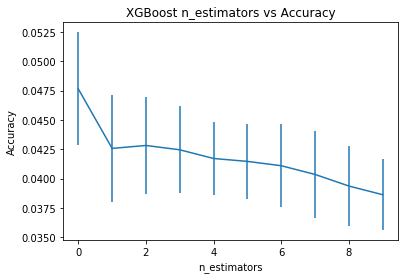

In [41]:
xgb_param = {
 'learning_rate': 0.03,
 'num_boost_round': 1000,
 'max_depth': 6,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'multi:softmax',
 'num_class': num_classes,
 'nthread': -1,
 'scale_pos_weight': 1,
 'seed': 2017}
cvresult = xgb.cv(xgb_param, xgtrain, nfold=10, stratified=True,
                  metrics='merror', early_stopping_rounds=100)
print('Best n_estimators value', cvresult.shape[0])
print(cvresult.tail(5))

pyplot.errorbar(cvresult.index, cvresult['train-merror-mean'], yerr=cvresult['train-merror-std'])
pyplot.title("XGBoost n_estimators vs Accuracy")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Accuracy')
pyplot.savefig('n_estimators.png')

#CV search

In [10]:
model = xgb.XGBClassifier()
n_estimators = range(100, 1000, 100)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2017)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=10)
grid_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Accuracy")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Accuracy')
pyplot.savefig('n_estimators.png')

Fitting 10 folds for each of 7 candidates, totalling 70 fits


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

In [ ]:
model = XGBClassifier()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
model = xgb.XGBClassifier()
n_estimators = range(100, 1000, 100)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=2017)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=10)
grid_result = grid_search.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Accuracy")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Accuracy')
pyplot.savefig('n_estimators.png')

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   1%|▏         | 1318/100000 [00:00<00:07, 13173.10it/s]

MorphologyExtractor transform:   2%|▏         | 2363/100000 [00:00<00:08, 11658.19it/s]

MorphologyExtractor transform:   4%|▍         | 3767/100000 [00:00<00:07, 12443.39it/s]

MorphologyExtractor transform:   5%|▍         | 4596/100000 [00:00<00:10, 9444.87it/s] 

MorphologyExtractor transform:   6%|▌         | 5531/100000 [00:00<00:10, 9423.64it/s]

MorphologyExtractor transform:   7%|▋         | 6557/100000 [00:00<00:09, 9545.32it/s]

MorphologyExtractor transform:   8%|▊         | 7533/100000 [00:00<00:09, 9571.73it/s]

MorphologyExtractor transform:   8%|▊         | 8424/100000 [00:00<00:09, 9367.94it/s]

MorphologyExtractor transform:   9%|▉         | 9286/100000 [00:01<00:09, 9271.78it/s]

MorphologyExtractor transform:  11%|█         | 11076/100000 [00:01<00:08, 10054.81it/s]

MorphologyExtractor transform:  12%|█▏        | 12212/100000 [00:01<00:08, 10076.64it/s]

MorphologyExtractor transform:  14%|█▍        | 14355/100000 [00:01<00:07, 10941.18it/s]

MorphologyExtractor transform:  16%|█▋        | 16348/100000 [00:01<00:07, 11577.78it/s]

MorphologyExtractor transform:  18%|█▊        | 18485/100000 [00:01<00:06, 12225.25it/s]

MorphologyExtractor transform:  21%|██        | 20686/100000 [00:01<00:06, 12832.04it/s]

MorphologyExtractor transform:  23%|██▎       | 22875/100000 [00:01<00:05, 13361.03it/s]

MorphologyExtractor transform:  25%|██▌       | 25180/100000 [00:01<00:05, 13895.63it/s]

MorphologyExtractor transform:  27%|██▋       | 27444/100000 [00:01<00:05, 14352.26it/s]

MorphologyExtractor transform:  30%|██▉       | 29802/100000 [00:02<00:04, 14809.92it/s]

MorphologyExtractor transform:  32%|███▏      | 32001/100000 [00:02<00:04, 14609.67it/s]

MorphologyExtractor transform:  34%|███▍      | 34363/100000 [00:02<00:04, 15003.01it/s]

MorphologyExtractor transform:  37%|███▋      | 36647/100000 [00:02<00:04, 15330.56it/s]

MorphologyExtractor transform:  39%|███▉      | 39024/100000 [00:02<00:03, 15668.78it/s]

MorphologyExtractor transform:  41%|████▏     | 41347/100000 [00:02<00:03, 15959.97it/s]

MorphologyExtractor transform:  44%|████▎     | 43679/100000 [00:02<00:03, 16232.82it/s]

MorphologyExtractor transform:  46%|████▌     | 46198/100000 [00:02<00:03, 16553.79it/s]

MorphologyExtractor transform:  49%|████▊     | 48683/100000 [00:02<00:03, 16834.81it/s]

MorphologyExtractor transform:  51%|█████     | 51058/100000 [00:03<00:02, 16635.24it/s]

MorphologyExtractor transform:  54%|█████▎    | 53683/100000 [00:03<00:02, 16937.25it/s]

MorphologyExtractor transform:  56%|█████▋    | 56271/100000 [00:03<00:02, 17210.45it/s]

MorphologyExtractor transform:  59%|█████▉    | 58962/100000 [00:03<00:02, 17498.31it/s]

MorphologyExtractor transform:  61%|██████▏   | 61406/100000 [00:03<00:02, 17694.78it/s]

MorphologyExtractor transform:  64%|██████▍   | 63984/100000 [00:03<00:02, 17921.15it/s]

MorphologyExtractor transform:  67%|██████▋   | 66579/100000 [00:03<00:01, 18139.43it/s]

MorphologyExtractor transform:  69%|██████▉   | 69204/100000 [00:03<00:01, 18354.45it/s]

MorphologyExtractor transform:  72%|███████▏  | 71849/100000 [00:03<00:01, 18563.41it/s]

MorphologyExtractor transform:  74%|███████▍  | 74426/100000 [00:04<00:01, 18330.57it/s]

MorphologyExtractor transform:  77%|███████▋  | 77055/100000 [00:04<00:01, 18521.78it/s]

MorphologyExtractor transform:  80%|███████▉  | 79653/100000 [00:04<00:01, 18696.72it/s]

MorphologyExtractor transform:  82%|████████▏ | 82377/100000 [00:04<00:00, 18892.12it/s]

MorphologyExtractor transform:  85%|████████▌ | 85024/100000 [00:04<00:00, 19061.48it/s]

MorphologyExtractor transform:  88%|████████▊ | 87712/100000 [00:04<00:00, 19232.34it/s]

MorphologyExtractor transform:  90%|█████████ | 90348/100000 [00:04<00:00, 19385.22it/s]

MorphologyExtractor transform:  93%|█████████▎| 92973/100000 [00:04<00:00, 19529.14it/s]

MorphologyExtractor transform:  96%|█████████▌| 95654/100000 [00:04<00:00, 19678.87it/s]

MorphologyExtractor transform:  98%|█████████▊| 98285/100000 [00:04<00:00, 19793.33it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:05<00:00, 19864.93it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   1%|          | 1215/100000 [00:00<00:08, 12141.39it/s]

MorphologyExtractor transform:   2%|▏         | 2498/100000 [00:00<00:09, 10592.06it/s]

MorphologyExtractor transform:   4%|▍         | 4415/100000 [00:00<00:07, 13142.65it/s]

MorphologyExtractor transform:   6%|▋         | 6473/100000 [00:00<00:06, 14847.69it/s]

MorphologyExtractor transform:   9%|▊         | 8564/100000 [00:00<00:05, 15978.27it/s]

MorphologyExtractor transform:  11%|█         | 10706/100000 [00:00<00:05, 16832.43it/s]

MorphologyExtractor transform:  13%|█▎        | 12939/100000 [00:00<00:04, 17578.27it/s]

MorphologyExtractor transform:  15%|█▌        | 15088/100000 [00:00<00:04, 18045.30it/s]

MorphologyExtractor transform:  17%|█▋        | 17279/100000 [00:00<00:04, 18457.41it/s]

MorphologyExtractor transform:  20%|█▉        | 19667/100000 [00:01<00:04, 18977.67it/s]

MorphologyExtractor transform:  22%|██▏       | 21799/100000 [00:01<00:04, 17993.65it/s]

MorphologyExtractor transform:  24%|██▍       | 24199/100000 [00:01<00:04, 18450.78it/s]

MorphologyExtractor transform:  26%|██▋       | 26475/100000 [00:01<00:03, 18755.70it/s]

MorphologyExtractor transform:  29%|██▉       | 29094/100000 [00:01<00:03, 19247.14it/s]

MorphologyExtractor transform:  31%|███▏      | 31463/100000 [00:01<00:03, 19522.57it/s]

MorphologyExtractor transform:  34%|███▍      | 33815/100000 [00:01<00:03, 19755.94it/s]

MorphologyExtractor transform:  36%|███▋      | 36250/100000 [00:01<00:03, 20009.44it/s]

MorphologyExtractor transform:  39%|███▊      | 38684/100000 [00:01<00:03, 20235.56it/s]

MorphologyExtractor transform:  41%|████      | 41056/100000 [00:02<00:03, 19449.92it/s]

MorphologyExtractor transform:  44%|████▎     | 43532/100000 [00:02<00:02, 19686.95it/s]

MorphologyExtractor transform:  46%|████▌     | 45986/100000 [00:02<00:02, 19896.63it/s]

MorphologyExtractor transform:  49%|████▉     | 48763/100000 [00:02<00:02, 20223.22it/s]

MorphologyExtractor transform:  51%|█████▏    | 51405/100000 [00:02<00:02, 20469.88it/s]

MorphologyExtractor transform:  54%|█████▍    | 54192/100000 [00:02<00:02, 20753.13it/s]

MorphologyExtractor transform:  57%|█████▋    | 56761/100000 [00:02<00:02, 20928.17it/s]

MorphologyExtractor transform:  59%|█████▉    | 59440/100000 [00:02<00:01, 21135.90it/s]

MorphologyExtractor transform:  62%|██████▏   | 62209/100000 [00:02<00:01, 21360.90it/s]

MorphologyExtractor transform:  65%|██████▍   | 64935/100000 [00:03<00:01, 21556.69it/s]

MorphologyExtractor transform:  68%|██████▊   | 67607/100000 [00:03<00:01, 20990.39it/s]

MorphologyExtractor transform:  70%|███████   | 70101/100000 [00:03<00:01, 21109.26it/s]

MorphologyExtractor transform:  73%|███████▎  | 72700/100000 [00:03<00:01, 21251.79it/s]

MorphologyExtractor transform:  75%|███████▌  | 75370/100000 [00:03<00:01, 21405.66it/s]

MorphologyExtractor transform:  78%|███████▊  | 78032/100000 [00:03<00:01, 21549.63it/s]

MorphologyExtractor transform:  81%|████████  | 80643/100000 [00:03<00:00, 21671.88it/s]

MorphologyExtractor transform:  83%|████████▎ | 83423/100000 [00:03<00:00, 21831.83it/s]

MorphologyExtractor transform:  86%|████████▌ | 86085/100000 [00:03<00:00, 21953.89it/s]

MorphologyExtractor transform:  89%|████████▊ | 88722/100000 [00:04<00:00, 22051.49it/s]

MorphologyExtractor transform:  91%|█████████▏| 91342/100000 [00:04<00:00, 22127.87it/s]

MorphologyExtractor transform:  94%|█████████▍| 93928/100000 [00:04<00:00, 22212.79it/s]

MorphologyExtractor transform:  97%|█████████▋| 96509/100000 [00:04<00:00, 22294.10it/s]

MorphologyExtractor transform:  99%|█████████▉| 99137/100000 [00:04<00:00, 22383.99it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:04<00:00, 21697.81it/s]

MorphologyExtractor transform:   0%|          | 0/100000 [00:00<?, ?it/s]

MorphologyExtractor transform:   1%|          | 1175/100000 [00:00<00:08, 11636.76it/s]

MorphologyExtractor transform:   3%|▎         | 3264/100000 [00:00<00:05, 16237.75it/s]

MorphologyExtractor transform:   5%|▌         | 5303/100000 [00:00<00:05, 17616.12it/s]

MorphologyExtractor transform:   7%|▋         | 7445/100000 [00:00<00:04, 18563.30it/s]

MorphologyExtractor transform:  10%|▉         | 9666/100000 [00:00<00:04, 19290.56it/s]

MorphologyExtractor transform:  12%|█▏        | 11918/100000 [00:00<00:04, 19825.86it/s]

MorphologyExtractor transform:  14%|█▍        | 14358/100000 [00:00<00:04, 20478.02it/s]

MorphologyExtractor transform:  16%|█▋        | 16403/100000 [00:00<00:04, 20327.20it/s]

MorphologyExtractor transform:  18%|█▊        | 18415/100000 [00:00<00:04, 19603.37it/s]

MorphologyExtractor transform:  20%|██        | 20279/100000 [00:01<00:04, 18802.20it/s]

MorphologyExtractor transform:  22%|██▏       | 22303/100000 [00:01<00:04, 18922.40it/s]

MorphologyExtractor transform:  25%|██▍       | 24596/100000 [00:01<00:03, 19231.25it/s]

MorphologyExtractor transform:  27%|██▋       | 26884/100000 [00:01<00:03, 19495.81it/s]

MorphologyExtractor transform:  30%|██▉       | 29591/100000 [00:01<00:03, 20005.45it/s]

MorphologyExtractor transform:  32%|███▏      | 31920/100000 [00:01<00:03, 20210.03it/s]

MorphologyExtractor transform:  34%|███▍      | 34343/100000 [00:01<00:03, 20447.48it/s]

MorphologyExtractor transform:  37%|███▋      | 36790/100000 [00:01<00:03, 20674.58it/s]

MorphologyExtractor transform:  39%|███▉      | 39144/100000 [00:01<00:03, 19583.61it/s]

MorphologyExtractor transform:  42%|████▏     | 41677/100000 [00:02<00:02, 19856.51it/s]

MorphologyExtractor transform:  44%|████▍     | 43931/100000 [00:02<00:02, 19978.50it/s]

MorphologyExtractor transform:  46%|████▌     | 46104/100000 [00:02<00:02, 19818.63it/s]

MorphologyExtractor transform:  48%|████▊     | 48137/100000 [00:02<00:02, 19583.04it/s]

MorphologyExtractor transform:  50%|█████     | 50023/100000 [00:02<00:02, 19539.61it/s]

MorphologyExtractor transform:  53%|█████▎    | 52660/100000 [00:02<00:02, 19795.56it/s]

MorphologyExtractor transform:  55%|█████▌    | 55302/100000 [00:02<00:02, 20029.06it/s]

MorphologyExtractor transform:  58%|█████▊    | 57984/100000 [00:02<00:02, 20266.17it/s]

MorphologyExtractor transform:  61%|██████    | 60526/100000 [00:02<00:01, 20440.17it/s]

MorphologyExtractor transform:  63%|██████▎   | 63123/100000 [00:03<00:01, 20620.20it/s]

MorphologyExtractor transform:  66%|██████▌   | 65798/100000 [00:03<00:01, 20814.02it/s]

MorphologyExtractor transform:  68%|██████▊   | 68337/100000 [00:03<00:01, 20173.27it/s]

MorphologyExtractor transform:  71%|███████   | 71125/100000 [00:03<00:01, 20394.13it/s]

MorphologyExtractor transform:  74%|███████▎  | 73747/100000 [00:03<00:01, 20556.45it/s]

MorphologyExtractor transform:  76%|███████▌  | 76155/100000 [00:03<00:01, 20647.54it/s]

MorphologyExtractor transform:  79%|███████▊  | 78746/100000 [00:03<00:01, 20786.27it/s]

MorphologyExtractor transform:  81%|████████▏ | 81254/100000 [00:03<00:00, 20894.85it/s]

MorphologyExtractor transform:  84%|████████▍ | 83782/100000 [00:03<00:00, 21004.40it/s]

MorphologyExtractor transform:  86%|████████▋ | 86369/100000 [00:04<00:00, 21123.34it/s]

MorphologyExtractor transform:  89%|████████▉ | 88990/100000 [00:04<00:00, 21244.41it/s]

MorphologyExtractor transform:  92%|█████████▏| 91538/100000 [00:04<00:00, 21332.56it/s]

MorphologyExtractor transform:  94%|█████████▍| 94191/100000 [00:04<00:00, 21450.80it/s]

MorphologyExtractor transform:  97%|█████████▋| 96796/100000 [00:04<00:00, 21552.54it/s]

MorphologyExtractor transform:  99%|█████████▉| 99399/100000 [00:04<00:00, 21650.07it/s]

MorphologyExtractor transform: 100%|██████████| 100000/100000 [00:04<00:00, 21657.18it/s]